### Utilizing CNNs To Classify Respiratory Illnesses From Audio Recordings

Fatih Catpinar

### The Data is from Kaggle
https://www.kaggle.com/vbookshelf/respiratory-sound-database

In [1]:
# # Note: Must install the following first in terminal first
# tensorflow
# soundfile

from os import listdir
from os.path import isfile, join
import time
import pickle

# to play an audio file
import IPython
import IPython.display as ipd 

import numpy as np
import pandas as pd

# for sound
import wave
from scipy.io import wavfile
import soundfile as sf

import tensorflow as tf
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

In [2]:
begin_start_time = time.time()

### Explore and load Data

In [3]:
# storing audio file names

# folder path for audio files
mypath = "respiratory-sound-database/" \
         "Respiratory_Sound_Database/" \
         "Respiratory_Sound_Database/audio_and_txt_files/"

# create a list of file names (only get .wav files)
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

# full paths of files
filepaths = [join(mypath, f) for f in filenames] 

print("Number of audio files: {}".format(len(filenames)))
print("Number of unique audio files: {}".format(len(set(filenames))))

Number of audio files: 920
Number of unique audio files: 920


In [4]:
# extracting the patient IDs

# an example of audio file name: 101_1b1_Al_sc_Meditron.wav
# first 3 digits are patient IDs

p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

print("Number of patient IDs: {}".format(len(p_id_in_file)))
print("Number of unique patient IDs: {}".format(len(set(p_id_in_file))))

Number of patient IDs: 920
Number of unique patient IDs: 126


In [5]:
# create the labes for the classes

# (we have the patient diagnosis csv file. In this file,
# there are two colums: patient IDs and diagnosis,
# by using the patient IDs we can create the labels for each audio file)

# patient diagnosis file path
diag_path = "respiratory-sound-database/" \
            "Respiratory_Sound_Database/" \
            "Respiratory_Sound_Database/patient_diagnosis.csv"

p_diag = pd.read_csv(diag_path, header=None)

# labels for audio files
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file])

print("Number of labels: {}".format(len(labels)))
print("Number of unique labels: {}".format(len(set(labels))))

Number of labels: 920
Number of unique labels: 8


In [6]:
# print class counts
unique_elements, counts_elements = np.unique(labels, return_counts=True)

for i in range(len(unique_elements)):
    print("{}".format(unique_elements[i]) 
          +" "*(15-len(unique_elements[i])) + ": "
          + "{}".format(counts_elements[i]))

Asthma         : 1
Bronchiectasis : 16
Bronchiolitis  : 13
COPD           : 793
Healthy        : 35
LRTI           : 2
Pneumonia      : 37
URTI           : 23


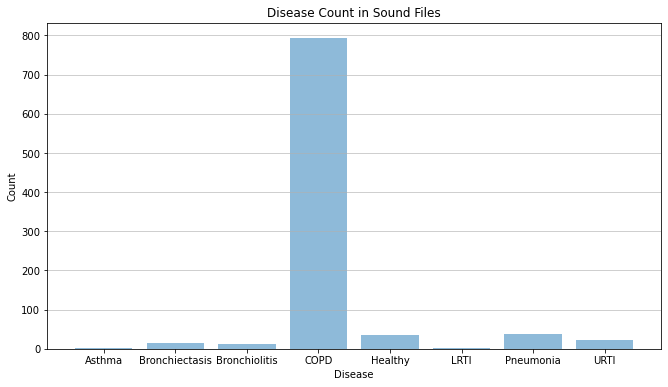

In [7]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(11,6))
plt.grid(axis='y', alpha=0.75)
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

In [8]:
# as an example: listen an audio file

# there are 920 audio files
# you can change the index number to listen a specific audio

audio_idx = np.random.randint(920) # randomly choose between 0 and 920
# audio_idx = 3

print("The label index: {}".format(audio_idx))
print("The label: {}".format(labels[audio_idx]))

# play the first audio
IPython.display.display(ipd.Audio(filepaths[audio_idx]))

The label index: 98
The label: URTI


In [9]:
# we have two main element of the raw data

# Bit-depth: The amplitude of each sample in the audio.
# if it is 16, the amplitude is one of 2^16 (=65536) possible values.

# Samplig rate = Number of samples in each second
# if it is 44.1 kHz, each second in the audio consists of 44100 samples.

Data bit depth: PCM_24
Sampling (frame) rate =  44100
Total samples (frames) =  (882000,)
Duration = 20.0 seconds

The raw data of a audio file:
[-0.05810535 -0.05789173 -0.05773914 ...  0.00311279  0.00320435
  0.00335693]


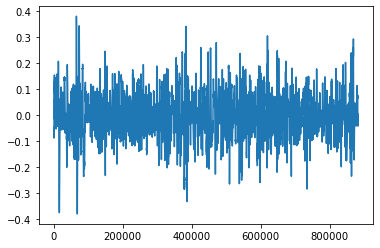

In [10]:
data, samplerate = sf.read(filepaths[audio_idx], dtype='float64')

# We have both 16bit and 24bit data, we converted the raw data to Floating point audio data
# Floating point audio data is typically in the range from -1.0 to 1.0. Integer data is in the range from -2**15 to
# 2**15-1 for 'int16' and from -2**31 to 2**31-1 for 'int32'.

file = sf.SoundFile(filepaths[audio_idx])
print("Data bit depth: {}".format(file.subtype))

print("Sampling (frame) rate = ", samplerate)
print("Total samples (frames) = ", data.shape)

print("Duration = {} seconds".format(data.shape[0] / samplerate))

print("\nThe raw data of a audio file:")
print(data)

# plot the data
plt.plot(data, '-', )
plt.show()

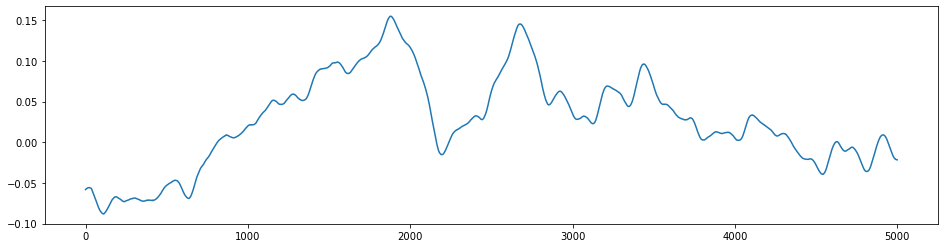

In [11]:
# first 5000 data points

plt.figure(figsize=(16, 4))
plt.plot(data[:5000], '-')
plt.show()

In [12]:
# Note that we could use wavfile.read to read the raw data
# which return the sample rate (in samples/sec) and data from a WAV file
# But this function cannot read wav files with 24-bit data.
# asmentioned before we have 24-bit data as well

In [13]:
# Iterate through each sound file and load the raw data

start_time = time.time()

data_all = []
samplerate_all = []
lengths_sec = []
lengths_n_data_points = []
for file_name in filepaths:
    data, samplerate = sf.read(file_name, dtype='float64')
    data_all.append(data)
    samplerate_all.append(samplerate)
    lengths_sec.append(len(data)/samplerate) # in seconds
    lengths_n_data_points.append(len(data))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.977144002914429 seconds ---


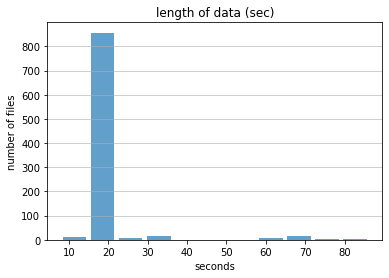

In [14]:
plt.hist(lengths_sec, bins = 'auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('seconds')
plt.ylabel('number of files')
plt.title('length of data (sec)')
plt.show()

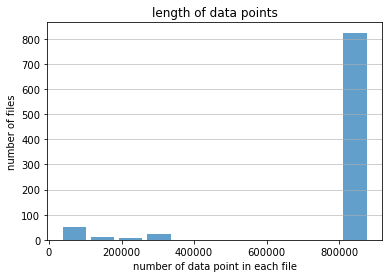

In [15]:
plt.hist(lengths_n_data_points, bins = 'auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('number of data point in each file')
plt.ylabel('number of files')
plt.title('length of data points')
plt.show()

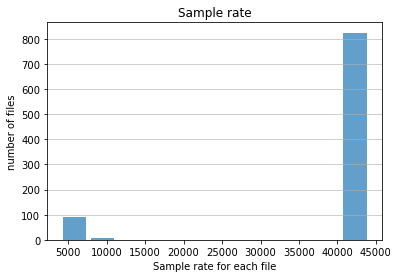

In [16]:
plt.hist(samplerate_all, bins = 'auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Sample rate for each file')
plt.ylabel('number of files')
plt.title('Sample rate')
plt.show()

In [17]:
# Files length are between 10 sec and 90 sec, majority of the audio files are 20 sec.
# and mojority of them are 44.1 khz

In [18]:
# normalize between 0 and 1
def normalize(data):
    max_data = np.max(data)
    min_data = np.min(data)
    eps = 1e-10 # added epsilons in case divide by zero error.
    data = (data-min_data)/(max_data-min_data+eps)
    return data

In [19]:
def standardize(data):
    data_mean = np.mean(data)
    data_std = np.std(data, ddof=1)
    eps = 1e-10 # added epsilons in case divide by zero error.
    data = (data - data_mean+eps) / (data_std+eps)
    return data

In [20]:
# padding
def pad(data,input_length,pad_constant):
    if len(data) > input_length:
        max_offset = len(data) - input_length
        offset = np.random.randint(max_offset)
        data = data[offset:(input_length+offset)]
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)
            offset = np.random.randint(max_offset)
        else:
            offset = 0
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant", constant_values=pad_constant)      
    return data

In [21]:
# using 2 seconds of data now, will change later

input_length = 44100*2
pad_constant= 0
data_padded = np.zeros([len(data_all),input_length,1])
for i in range(len(data_all)):
    data = pad(data_all[i],input_length,pad_constant)
    data_padded[i] = data.reshape(len(data),1)
    
print(data_padded.shape)

(920, 88200, 1)


### More pre-processing

In [22]:
# one class outnumber the others by a large proportion.
# as seen the imbalanced ruined the model

# to do:
# delete the rare clases
# split with same distrubution
# apply SMOTE to take care imbalanced data

/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


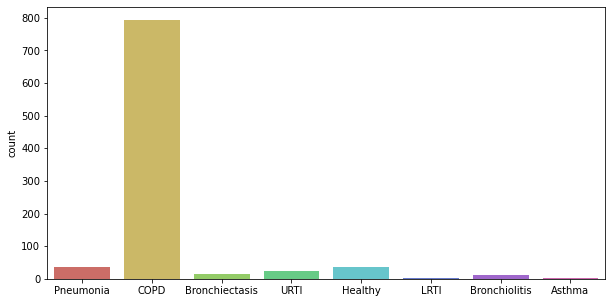

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(labels, palette='hls')
plt.show()

In [24]:
# deleting the very rare diseases: 'Asthma' and 'LRTI'

data_padded = np.delete(data_padded, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 
labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

print(data_padded.shape)
print(labels.shape)

(917, 88200, 1)
(917,)


/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


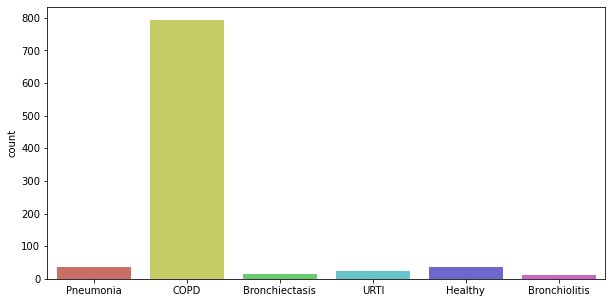

In [25]:
# after deleting rare diseases

plt.figure(figsize=(10,5))
sns.countplot(labels, palette='hls')
plt.show()

### Split data

In [26]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=0, stratify=labels)

In [27]:
# making sure the test and train disturbition is same for all classes
(unique, counts) = np.unique(y_train, axis=0, return_counts=True)

for i in range(len(unique)):
    print(unique[i], counts[i], counts[i]/np.sum(counts))

Bronchiectasis 13 0.017735334242837655
Bronchiolitis 10 0.013642564802182811
COPD 634 0.8649386084583902
Healthy 28 0.03819918144611187
Pneumonia 30 0.040927694406548434
URTI 18 0.02455661664392906


In [28]:
(unique, counts) = np.unique(y_test, axis=0, return_counts=True)
for i in range(len(unique)):
    print(unique[i], counts[i], counts[i]/np.sum(counts))

Bronchiectasis 3 0.016304347826086956
Bronchiolitis 3 0.016304347826086956
COPD 159 0.8641304347826086
Healthy 7 0.03804347826086957
Pneumonia 7 0.03804347826086957
URTI 5 0.02717391304347826


In [29]:
# SMOTE train data

start_time = time.time()

# reshape (smote does not accept 3 dim)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
print(x_train.shape)

# smote 
os = SMOTE(random_state=0)
x_train, y_train = os.fit_sample(x_train, y_train)

# reshape back
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(x_train.shape)

print("--- %s seconds ---" % (time.time() - start_time))

(733, 88200, 1)
(733, 88200)
(3804, 88200, 1)
--- 16.390382766723633 seconds ---


In [30]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3804, 88200, 1)
(3804,)
(184, 88200, 1)
(184,)


In [31]:
# shuffle after SMOTE

train_idx = list(range(len(x_train)))
np.random.shuffle(train_idx)

test_idx = list(range(len(x_test)))
np.random.shuffle(test_idx)

x_train = x_train[train_idx]
y_train = y_train[train_idx]
x_test = x_test[test_idx]
y_test = y_test[test_idx]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3804, 88200, 1)
(3804,)
(184, 88200, 1)
(184,)


/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


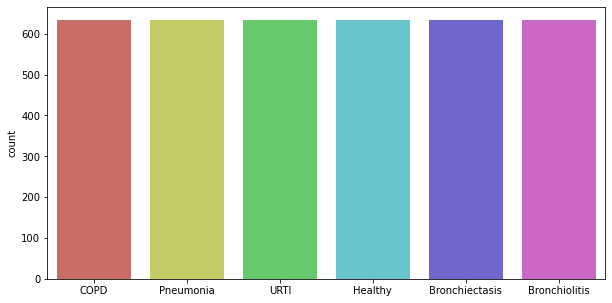

In [32]:
# train data after SMOTE

plt.figure(figsize=(10,5))
sns.countplot(y_train, palette='hls')
plt.show()

In [33]:
# one-hot encode train labels

# transform non-numerical labels to numerical labels
le_train = LabelEncoder()
y_train_encoded = le_train.fit_transform(y_train) 

# Converts a class vector (integers) to binary class matrix.
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded) 


# one-hot encode test labels

# transform non-numerical labels to numerical labels
le_test = LabelEncoder()
y_test_encoded = le_test.fit_transform(y_test) 

# Converts a class vector (integers) to binary class matrix.
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded) 

In [34]:
print(x_train.shape)
print(y_train_onehot.shape)
print(x_test.shape)
print(y_test_onehot.shape)

(3804, 88200, 1)
(3804, 6)
(184, 88200, 1)
(184, 6)


### Model

In [35]:
model = Sequential()

n_features = x_train.shape[2] 
n_timesteps = x_train.shape[1]
n_outputs = y_train_onehot.shape[1]

model.add(tf.keras.layers.Conv1D(filters=2, kernel_size=100, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling1D(pool_size=10))
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling1D(pool_size=10))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88101, 2)          202       
_________________________________________________________________
dropout (Dropout)            (None, 88101, 2)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8810, 2)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8711, 4)           804       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8711, 4)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 871, 4)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3484)              0

In [36]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test_onehot, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

# trianing
model.fit(x_train, y_train_onehot, epochs=7, batch_size=32, verbose=1)

# Calculate post-training accuracy 
score = model.evaluate(x_test, y_test_onehot, verbose=1)
accuracy = 100*score[1]

print("Post-training accuracy: %.4f%%" % accuracy)

6/6 [==============================] - 1s 63ms/step - loss: 1.8231 - accuracy: 0.0839
Pre-training accuracy: 5.9783%
Epoch 1/7
119/119 [==============================] - 200s 2s/step - loss: 0.5282 - accuracy: 0.8431
Epoch 2/7
119/119 [==============================] - 196s 2s/step - loss: 0.0708 - accuracy: 0.9840
Epoch 3/7
119/119 [==============================] - 194s 2s/step - loss: 0.0593 - accuracy: 0.9840
Epoch 4/7
119/119 [==============================] - 188s 2s/step - loss: 0.0532 - accuracy: 0.9890
Epoch 5/7
119/119 [==============================] - 182s 2s/step - loss: 0.0146 - accuracy: 0.9971
Epoch 6/7
119/119 [==============================] - 186s 2s/step - loss: 0.0089 - accuracy: 0.9984
Epoch 7/7
6/6 [==============================] - 0s 51ms/step - loss: 0.8322 - accuracy: 0.8152
Post-training accuracy: 81.5217%


In [37]:
y_test_hat = model.predict_classes(x_test)

/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [38]:
# pritn first 3 prediction and true class

for i in range(3):
    print("Predicted Class: {}, True Class: {}".format(y_test_hat[i], y_test_onehot[i]) )

Predicted Class: 2, True Class: [0. 0. 1. 0. 0. 0.]
Predicted Class: 0, True Class: [0. 0. 1. 0. 0. 0.]
Predicted Class: 2, True Class: [0. 0. 0. 0. 1. 0.]


In [39]:
y_test_decoded = tf.argmax(y_test_onehot, axis=1)

In [40]:
CM = tf.math.confusion_matrix(y_test_decoded, y_test_hat)
CM = np.array(CM)
CM

array([[  2,   0,   1,   0,   0,   0],
       [  0,   0,   3,   0,   0,   0],
       [  9,   0, 148,   1,   1,   0],
       [  0,   0,   5,   0,   1,   1],
       [  0,   0,   7,   0,   0,   0],
       [  0,   0,   5,   0,   0,   0]], dtype=int32)

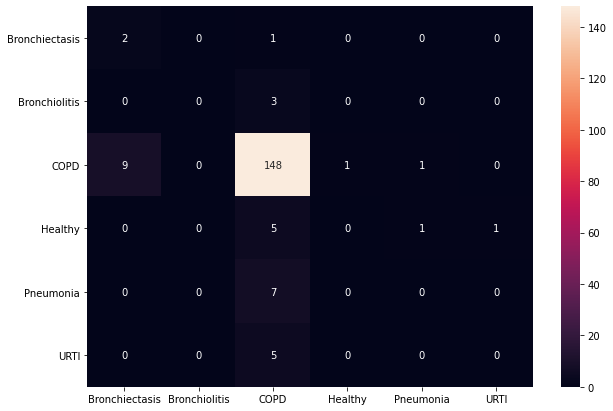

In [41]:
df_cm = pd.DataFrame(CM, index = [i for i in unique],
                  columns = [i for i in unique])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d")
plt.show()

/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


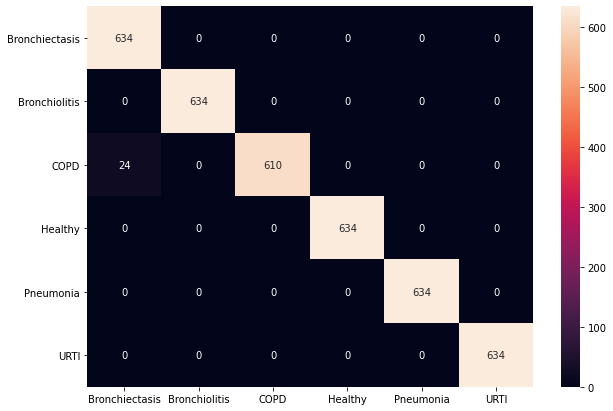

In [48]:
y_train_hat = model.predict_classes(x_train)
y_train_decoded = tf.argmax(y_train_onehot, axis=1)
CM = tf.math.confusion_matrix(y_train_decoded, y_train_hat)
CM = np.array(CM)
df_cm = pd.DataFrame(CM, index = [i for i in unique],
                  columns = [i for i in unique])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d")
plt.show()

In [47]:
# # smote the test data?

# # reshape (smote does not accept 3 dim)
# print(x_test.shape)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
# print(x_test.shape)

# # smote 
# os = SMOTE(random_state=0)
# x_test, y_test = os.fit_sample(x_test, y_test)

# # reshape back
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
# print(x_test.shape)


# # one-hot encode test labels

# # transform non-numerical labels to numerical labels
# le_test = LabelEncoder()
# y_test_encoded = le_test.fit_transform(y_test) 

# # Converts a class vector (integers) to binary class matrix.
# y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded) 